<a href="https://colab.research.google.com/github/gdario/DL-workshop-2017/blob/master/SiameseMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we create a siamese network to classify pairs of MNIST digits. The classifier must assess whether the two images represent the same digit or two different digits. For this purpose we build a `Dataset` that, for a given index `idx` will return with probability 0.5 a random image from the same class or an image from a different class. The model is just a MLP, and the purpose of this notebook is mainly to show how to build a non-standard `Dataset` and `DataLoader`.

In [1]:
import gzip
import pickle
import random
import requests
from pathlib import Path
from matplotlib import pyplot
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.current_device()

0

(50000, 784)


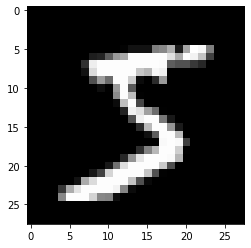

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(
            f, encoding="latin-1")

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

The `y_train` and `y_valid` labels are not the ones we will use in our model. These are the original labels `[0, ..., 9]`, while we will be using a binary label that is equal to `1` when two images represent the same digit.

In [3]:
y_valid.dtype

dtype('int64')

In [4]:
x_train, x_valid = torch.tensor(x_train), torch.tensor(x_valid)
# y_train, y_valid = torch.tensor(y_train), torch.tensor(y_valid)
x_train.dtype, x_valid.dtype, y_train.dtype, y_valid.dtype

(torch.float32, torch.float32, dtype('int64'), dtype('int64'))

In [5]:
y_valid[5].shape

()

We want to create a dataloader that returns, with the same probability, two different images of the same number, or two images of two different numbers. There are 10 classes, therefore the probability of each class is 1/10. The probability of getting the same number twice is therefore 1/00 = 0.01. There are 10 classes, therefore the probability of getting the same class twice is 10%. We generate pairs of class labels c1 and c2 and with probability 60% we set c2 to the same value of c1. The cutoff is 60% because 10% of the cases will contain the same class anyway.

In [6]:
class MNISTpairSet(Dataset):
    def __init__(self, x_data, y_data):
        super().__init__()
        self.x = x_data
        self.y = y_data
        self.classes = torch.tensor([[0], [1]], dtype=torch.float32)

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        x1 = self.x[idx]
        y1 = self.y[idx]
        y2 = random.randint(0, 9)
        if random.random() > 0.6:
            y2 = y1
        tmp = self.x[self.y == y2]
        # idx2 = torch.randint(low=0, high=tmp.shape[0], size=(1,)).item()
        idx2 = random.randint(0, tmp.shape[0] - 1)
        x2 = tmp[idx2]
        y = self.classes[1] if y1 == y2 else self.classes[0]
        # sample = {'x1': x1, 'x2': x2, 'y': y}
        return (x1, x2, y)

The model below contains two layers the weights of which are shared betwee the two branches.

In [7]:
dataset_train = MNISTpairSet(x_train, y_train)
dataset_valid = MNISTpairSet(x_valid, y_valid)

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=False)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=False)

In [8]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_linear1 = nn.Linear(in_features=784, out_features=256)
        self.shared_linear2 = nn.Linear(in_features=256, out_features=128)
        self.linear1 = nn.Linear(in_features=256, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=1)

    def forward(self, x1, x2):
        x1 = F.relu(self.shared_linear1(x1))
        x2 = F.relu(self.shared_linear1(x2))
        x1 = F.relu(self.shared_linear2(x1))
        x2 = F.relu(self.shared_linear2(x2))
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [9]:
def training_loop(train_loader, valid_loader, device, model, loss_fn,
                  optimizer):
    losses = []
    batch_num = 0
    for x1, x2, y in train_loader:
        batch_num += 1
        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)
        preds = model(x1, x2)
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_num % 200 == 0:
            print('Batch: {}, Train loss: {:.4f}'.format(
                batch_num+1, loss.item()))
            validation_loop(valid_loader, device, model, loss_fn)

In [10]:
def validation_loop(dataloader, device, model, loss_fn):
    size = len(dataloader)  # Number of minibatches, not of observations
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x1, x2, y in dataloader:
            x1 = x1.to(device)
            x2 = x2.to(device)
            y = y.to(device)
            preds = model(x1, x2)
            test_loss += loss_fn(preds, y)
            yhat = (torch.sigmoid(preds) > 0.5).type(torch.float)
            correct += (yhat == y).type(torch.float).mean().item()
        test_loss /= size
        correct /= size
        print(f'Test Loss: {test_loss:>.4} - Test Accuracy {correct:>0.3f}')

In [ ]:
NUM_EPOCHS = 5

model = SiameseNet()
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

for epoch in range(NUM_EPOCHS):
    print('Epoch: {}'.format(epoch))
    print('-----------------------')
    training_loop(dataloader_train, dataloader_valid, device, model,
                  loss_fn, optimizer)

Epoch: 0
-----------------------
Batch: 201, Train loss: 0.4306
Test Loss: 0.4465 - Test Accuracy 0.782
Batch: 401, Train loss: 0.3244
Test Loss: 0.3412 - Test Accuracy 0.856
Batch: 601, Train loss: 0.2609
Test Loss: 0.2652 - Test Accuracy 0.896
